In [5]:
from Libreria.cargar_configbd import cargar_configbd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

import joblib

In [6]:
# Conectar a la base de datos PostgreSQL
conn = cargar_configbd.conectar_base_datos('conf_bd.txt')
cur = conn.cursor()

In [7]:
cur.execute(f"SELECT * FROM datos_uda_reglas;") # Son los viajes etiqetados por toda lo metodologia
# Obtener los resultados de la consulta
rows = cur.fetchall()

df_modos = pd.DataFrame(rows.copy(), columns=[desc[0] for desc in cur.description])

num_elementos_por_grupo = df_modos.groupby('etiqueta').size()
print(num_elementos_por_grupo)

etiqueta
AUTOMOVIL    110
BICICLETA    110
BUS          110
CAMINATA     110
dtype: int64


In [8]:
def DecisionTree(X, y, test_size):
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Entrenar un árbol de decisión
    tree_classifier = DecisionTreeClassifier(random_state=42)
    tree_classifier.fit(X_train, y_train)

    # Predecir las etiquetas en el conjunto de prueba
    y_pred_test = tree_classifier.predict(X_test)
    y_pred_train = tree_classifier.predict(X_train)

    # Calcular y mostrar la precisión del modelo en el conjunto de prueba
    acurracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # Calcular y mostrar la matriz de confusión con nombres de clase
    conf_matrix = confusion_matrix(y_test, y_pred_test, labels=tree_classifier.classes_)
    # Calcular y mostrar el reporte de clasificación
    class_report = classification_report(y_test, y_pred_test, target_names=tree_classifier.classes_, zero_division=0)

    return tree_classifier, acurracy_train, accuracy_test, conf_matrix, class_report

def SVM(X, y, test_size):
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Inicializar y entrenar el clasificador SVM
    svm_classifier = SVC()
    svm_classifier.fit(X_train, y_train)

    # Predecir las etiquetas en el conjunto de prueba
    y_pred_train = svm_classifier.predict(X_train)
    y_pred_test = svm_classifier.predict(X_test)

    # Calcular y mostrar la precisión del modelo en el conjunto de prueba
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # Calcular y mostrar la matriz de confusión con nombres de clase
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    # Calcular y mostrar el reporte de clasificación
    class_report = classification_report(y_test, y_pred_test, target_names=svm_classifier.classes_, zero_division=0)

    return svm_classifier, accuracy_train, accuracy_test, conf_matrix, class_report

def XGBOOST(X, y_encoded, label_encoder, test_size):

    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, stratify=y_encoded, random_state=42)

    # Convertir los datos al formato requerido por XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Definir los parámetros del modelo
    params = {
        'objective': 'multi:softmax',  # Función objetivo para clasificación multiclase
        'num_class': len(set(y_encoded)),       # Número de clases en el conjunto de datos
        'eval_metric': 'merror'         # Métrica de evaluación: tasa de error de clasificación
    }

    # Entrenar el modelo
    num_rounds = 100  # Número de rondas de boosting (estimadores)
    bst_classifier = xgb.train(params, dtrain, num_rounds)

    # Realizar predicciones en el conjunto de prueba
    y_pred_test = bst_classifier.predict(dtest)
    y_pred_train = bst_classifier.predict(dtrain)

    # Calcular y mostrar la precisión del modelo en el conjunto de prueba
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    # Calcular y mostrar la matriz de confusión con nombres de clase
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    # Calcular y mostrar el reporte de clasificación
    class_report = classification_report(y_test, y_pred_test, target_names=label_encoder.classes_, zero_division=0)

    return bst_classifier, accuracy_train, accuracy_test, conf_matrix, class_report

def RandomForest(X, y, test_size):
    # Dividir el conjunto de datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # Inicializar y entrenar el modelo de Random Forest
    random_forest = RandomForestClassifier(random_state=42)
    random_forest.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de prueba
    y_pred_test = random_forest.predict(X_test)
    y_pred_train = random_forest.predict(X_train)

    # Calcular y mostrar la precisión del modelo en el conjunto de prueba
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    # Calcular y mostrar la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    # Calcular y mostrar el reporte de clasificación
    class_report = classification_report(y_test, y_pred_test, zero_division=0)

    return random_forest, accuracy_train, accuracy_test, conf_matrix, class_report

In [9]:
df = df_modos.copy()

In [10]:
def normalize_data(X):
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)
    return X_normalized_df

# Extraer las características (X) y las etiquetas (y) del DataFrame
X = df.iloc[:, 3:-1]  # Todas las filas, todas las columnas excepto la última
y = df.iloc[:, -1]   # Todas las filas, solo la última columna
# Codificar las etiquetas de la variable objetivo
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [11]:
# Aplica la selección de características univariadas con f_classif
k_value = 29
selector = SelectKBest(score_func=f_classif, k=k_value)
X_selected = selector.fit_transform(X, y)

# Obtén los índices de las características seleccionadas ordenadas por importancia
selected_feature_indices = np.argsort(selector.scores_)[::-1][:k_value]

# Obtén las características seleccionadas ordenadas por importancia
selected_features = X.columns[selected_feature_indices]

# Imprime las características seleccionadas en orden de importancia
print(selected_features)

joblib.dump(selected_features, 'selected_features.joblib')
print(f"Selected features guardadas en {'selected_features.joblib'}")

Index(['max_speed', 'mean_time_stop', 'max_time_stop', 'p25_speed',
       'mean_speed', 'p75_time_stop', 'p75_speed', 'var_time_stop',
       'median_time_stop', 'median_speed', 'p25_time_stop', 'stops',
       'p75_aceleration', 'var_bearing', 'min_speed', 'min_time_stop',
       'min_bearing', 'max_aceleration', 'var_speed', 'p25_bearing',
       'max_bearing', 'median_aceleration', 'mean_aceleration', 'p75_bearing',
       'min_aceleration', 'mean_bearing', 'var_aceleration', 'p25_aceleration',
       'median_bearing'],
      dtype='object')
Selected features guardadas en selected_features.joblib


In [12]:
selected_features = joblib.load('selected_features.joblib')
# Imprime las características seleccionadas en orden de importancia
print(selected_features)

Index(['max_speed', 'mean_time_stop', 'max_time_stop', 'p25_speed',
       'mean_speed', 'p75_time_stop', 'p75_speed', 'var_time_stop',
       'median_time_stop', 'median_speed', 'p25_time_stop', 'stops',
       'p75_aceleration', 'var_bearing', 'min_speed', 'min_time_stop',
       'min_bearing', 'max_aceleration', 'var_speed', 'p25_bearing',
       'max_bearing', 'median_aceleration', 'mean_aceleration', 'p75_bearing',
       'min_aceleration', 'mean_bearing', 'var_aceleration', 'p25_aceleration',
       'median_bearing'],
      dtype='object')


In [13]:
scores_tree = []
scores_svm = []
scores_bst = []
scores_rf = []

for i in range (1, 30):
    test_size = 0.3

    tree_classifier, tree_accuracy_train, tree_accuracy_test, tree_conf_matrix, tree_class_report = DecisionTree(X[selected_features[:i]], y, test_size=test_size)
    scores_tree.append([tree_accuracy_train, tree_accuracy_test])

    svm_classifier, svm_accuracy_train, svm_accuracy_test, svm_conf_matrix, svm_class_report = SVM(X[selected_features[:i]], y, test_size=test_size)
    scores_svm.append([svm_accuracy_train, svm_accuracy_test])

    bst_classifier, bst_accuracy_train, bst_accuracy_test, bst_conf_matrix, bst_class_report = XGBOOST(X[selected_features[:i]], y_encoded, label_encoder, test_size=test_size)
    scores_bst.append([bst_accuracy_train, bst_accuracy_test])

    rf_classifier, rf_accuracy_train, rf_accuracy_test, rf_conf_matrix, rf_class_report = RandomForest(X[selected_features[:i]], y, test_size=test_size)
    scores_rf.append([rf_accuracy_train, rf_accuracy_test])

In [14]:
model_scores = [[scores_tree, 'Arbol de Decision'], [scores_svm, 'SVM'], [scores_bst, 'Xgboost'], [scores_rf, 'Random Forest']]

ARBOL DE DECISION
[[1.0, 0.7], [1.0, 0.9], [1.0, 0.87], [1.0, 0.89], [1.0, 0.89], [1.0, 0.91], [1.0, 0.89], [1.0, 0.86], [1.0, 0.89], [1.0, 0.87], [1.0, 0.87], [1.0, 0.89], [1.0, 0.9], [1.0, 0.89], [1.0, 0.89], [1.0, 0.9], [1.0, 0.89], [1.0, 0.9], [1.0, 0.91], [1.0, 0.89], [1.0, 0.9], [1.0, 0.93], [1.0, 0.93], [1.0, 0.92], [1.0, 0.91], [1.0, 0.89], [1.0, 0.92], [1.0, 0.91], [1.0, 0.92]]


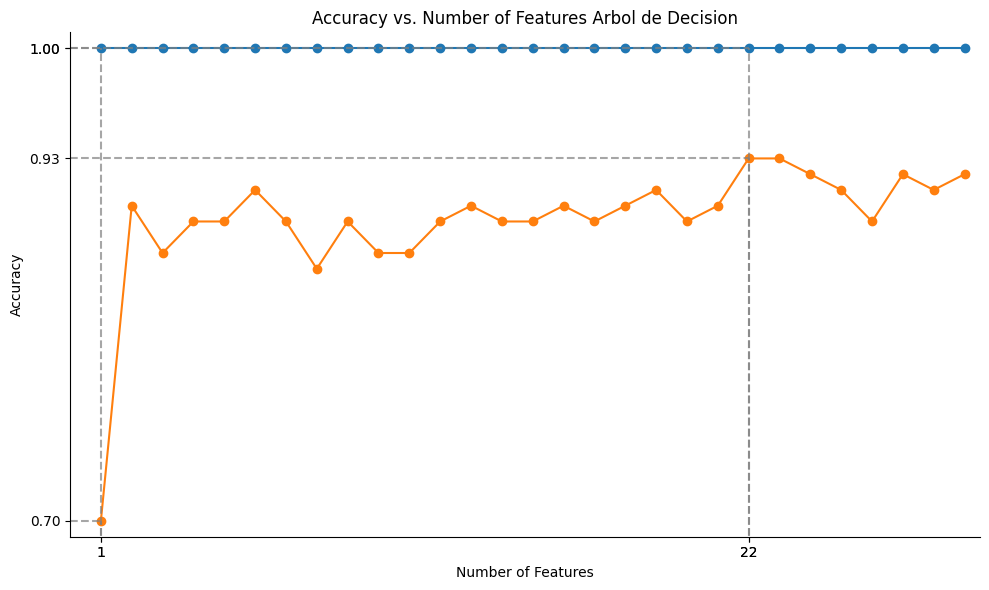

SVM
[[0.71, 0.72], [0.81, 0.76], [0.68, 0.63], [0.67, 0.62], [0.69, 0.62], [0.67, 0.62], [0.69, 0.63], [0.46, 0.41], [0.46, 0.41], [0.46, 0.41], [0.46, 0.41], [0.46, 0.41], [0.46, 0.41], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48], [0.59, 0.48]]


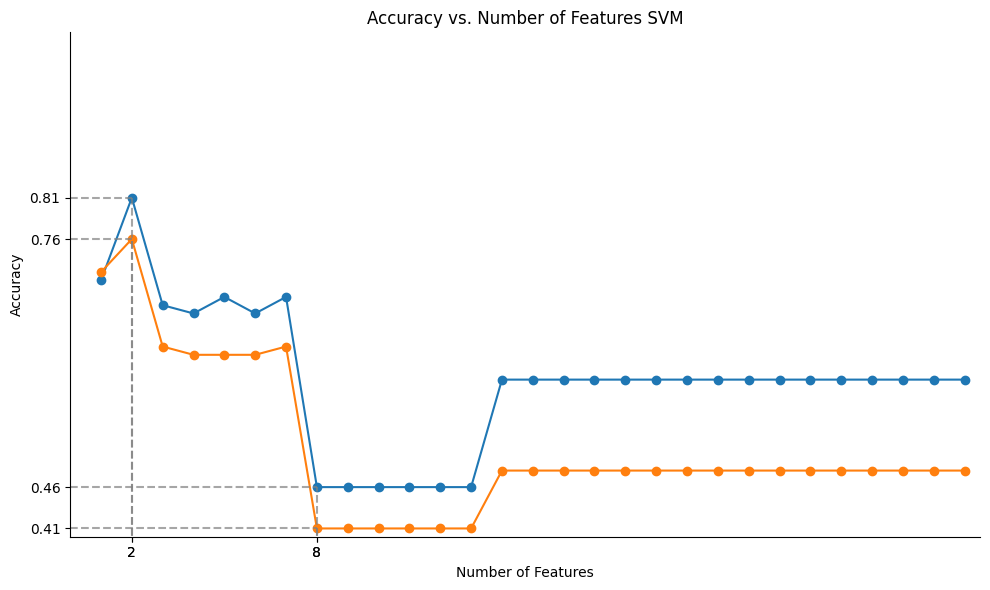

XGBOOST
[[0.93, 0.68], [1.0, 0.88], [1.0, 0.85], [1.0, 0.87], [1.0, 0.89], [1.0, 0.9], [1.0, 0.89], [1.0, 0.89], [1.0, 0.89], [1.0, 0.92], [1.0, 0.91], [1.0, 0.93], [1.0, 0.92], [1.0, 0.95], [1.0, 0.94], [1.0, 0.95], [1.0, 0.95], [1.0, 0.95], [1.0, 0.92], [1.0, 0.92], [1.0, 0.92], [1.0, 0.92], [1.0, 0.91], [1.0, 0.91], [1.0, 0.92], [1.0, 0.92], [1.0, 0.92], [1.0, 0.9], [1.0, 0.92]]


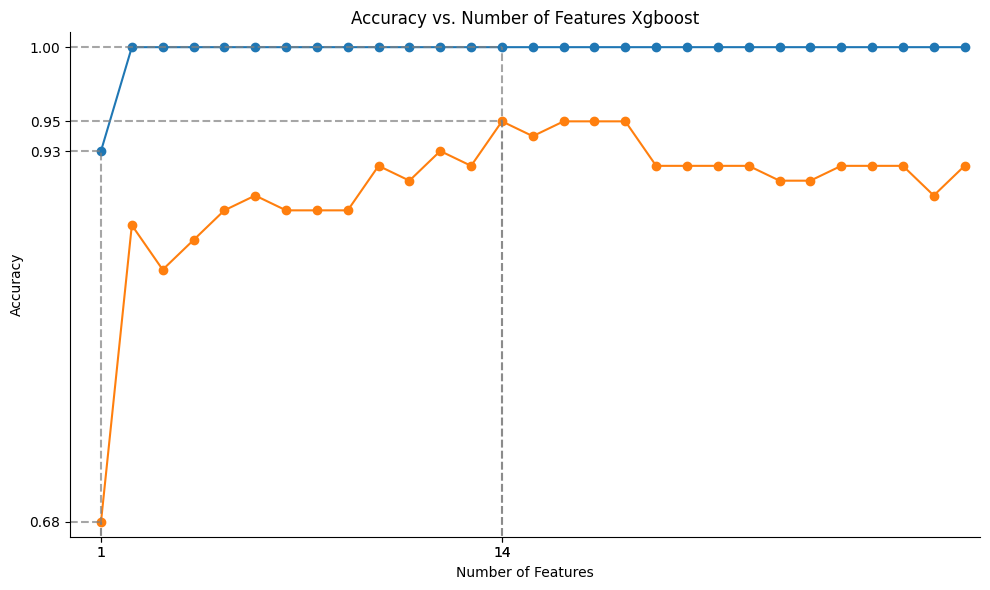

RANDOM FOREST
[[1.0, 0.7], [1.0, 0.89], [1.0, 0.89], [1.0, 0.92], [1.0, 0.9], [1.0, 0.94], [1.0, 0.92], [1.0, 0.95], [1.0, 0.92], [1.0, 0.93], [1.0, 0.94], [1.0, 0.95], [1.0, 0.95], [1.0, 0.95], [1.0, 0.93], [1.0, 0.94], [1.0, 0.95], [1.0, 0.93], [1.0, 0.93], [1.0, 0.93], [1.0, 0.94], [1.0, 0.94], [1.0, 0.92], [1.0, 0.95], [1.0, 0.93], [1.0, 0.92], [1.0, 0.92], [1.0, 0.93], [1.0, 0.95]]


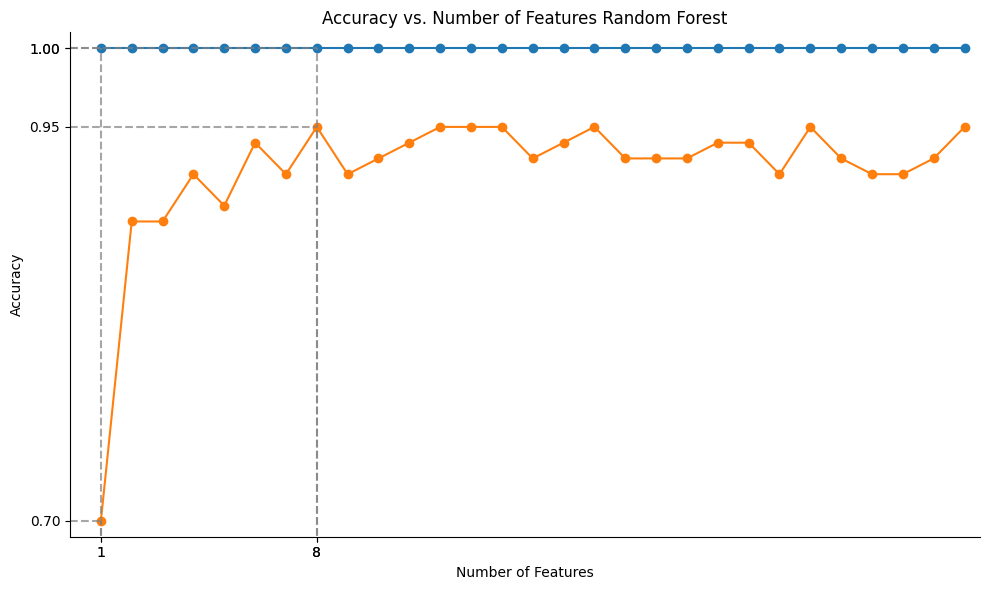

In [15]:
for scores, name in model_scores:
    print(name.upper())

    #print("Precisión del modelo en el conjunto de entrenamiento:\n", [round(score[0], 2) for score in scores])
    #print("Precisión del modelo en el conjunto de prueba:\n", [round(score[1], 2)for score in scores])

    # Diccionario para almacenar la primera aparición de cada número
    first_occurrences_prueba = {}

    # Iterar sobre la lista y registrar la primera aparición de cada número
    for index, value in enumerate([round(score[1], 2)for score in scores]):
        if value not in first_occurrences_prueba:
            first_occurrences_prueba[value] = index

    # Graficar los resultados
    plt.figure(figsize=(10, 6))

    print([[round(valor, 2) for valor in sublista] for sublista in scores])
    plt.plot(range(1, 30), [[round(valor, 2) for valor in sublista] for sublista in scores], marker='o', label=[f'{name} Train', f'{name} Test'])

    plt.title(f'Accuracy vs. Number of Features {name}')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')

    clave_maxima = max(first_occurrences_prueba, key=float)  # Suponiendo que los valores son representados como strings, convierte la clave a float
    idx_score_prueba_maximo = first_occurrences_prueba[clave_maxima] # Obtiene la posicion del primer scroe mas grande en la lista de scores

    clave_min = min(first_occurrences_prueba, key=float)  # Suponiendo que los valores son representados como strings, convierte la clave a float
    idx_score_prueba_minimo= first_occurrences_prueba[clave_min] # Obtiene la posicion del primer scroe mas grande en la lista de scores

    yticks_values = [round(scores[idx_score_prueba_minimo][0], 2), round(scores[idx_score_prueba_minimo][1], 2), round(scores[idx_score_prueba_maximo][0], 2), round(scores[idx_score_prueba_maximo][1], 2)]
    plt.yticks(yticks_values) # entrenamiento, prueba
    xticks_values = [idx_score_prueba_minimo + 1, idx_score_prueba_minimo + 1, idx_score_prueba_maximo + 1, idx_score_prueba_maximo + 1]
    plt.xticks(xticks_values)

    #max([round(score[0], 2)for score in scores] + [round(score[1], 2)for score in scores])
    plt.ylim(min([round(score[0], 2)for score in scores] + [round(score[1], 2)for score in scores])-0.01, 1+0.01)  
    plt.xlim(0, len(scores)+0.5)  

    # Dibujar líneas punteadas conectando los xticks con los yticks
    for x_cord, y_cord in zip(xticks_values, yticks_values):
        plt.plot([x_cord, x_cord], [0, y_cord], linestyle='--', color='grey', alpha=0.7)  # Línea vertical
        plt.plot([0, x_cord], [y_cord, y_cord], linestyle='--', color='grey', alpha=0.7)  # Línea horizontal


    # Eliminar la cuadrícula
    plt.grid(False)

    # Remover las líneas superior y derecha de la caja
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()